In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, average_precision_score
from xgboost import XGBClassifier
import shap

In [42]:
df = pd.read_csv("cumulative_2025.09.30_00.52.21.csv", comment='#')
df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,39.30,76.3,1.0,q1_q17_dr25_tce,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,891.96,505.6,1.0,q1_q17_dr25_tce,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,4500.53,453.3,1.0,q1_q17_dr25_tce,5638.0,4.529,0.903,297.18875,47.093819,14.082
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,1585.81,10.6,1.0,q1_q17_dr25_tce,6119.0,4.444,1.031,286.50937,47.163219,14.757
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,...,5713.41,12.3,1.0,q1_q17_dr25_tce,6173.0,4.447,1.041,294.16489,47.176281,15.385
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,...,22.68,14.0,1.0,q1_q17_dr25_tce,4989.0,2.992,7.824,296.76288,47.145142,10.998


In [43]:
df['target'] = df['koi_disposition'].map(lambda x: 1 if str(x).upper() in ['CONFIRMED', 'CANDIDATE'] else 0)

In [44]:
features = [
    'koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
    'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag',
    'koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec'
]

In [45]:
features = [c for c in features if c in df.columns]

In [46]:
X = df[features]
y = df['target']

In [47]:
# 4) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [48]:
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, eval_metric='logloss', use_label_encoder=False)

In [49]:
X_train_imputed = pd.DataFrame(num_imputer.fit_transform(X_train), columns=X_train.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train.columns)

xgb.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/foml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [50]:
X_test_imputed = pd.DataFrame(num_imputer.transform(X_test), columns=X_test.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test.columns)
probs = xgb.predict_proba(X_test_scaled)[:,1]

print("ROC AUC:", roc_auc_score(y_test, probs))
print("Average Precision (PR AUC):", average_precision_score(y_test, probs))

y_pred = (probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))


ROC AUC: 0.9985897940443395
Average Precision (PR AUC): 0.9982204406641214
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       968
           1       0.99      1.00      0.99       945

    accuracy                           0.99      1913
   macro avg       0.99      0.99      0.99      1913
weighted avg       0.99      0.99      0.99      1913



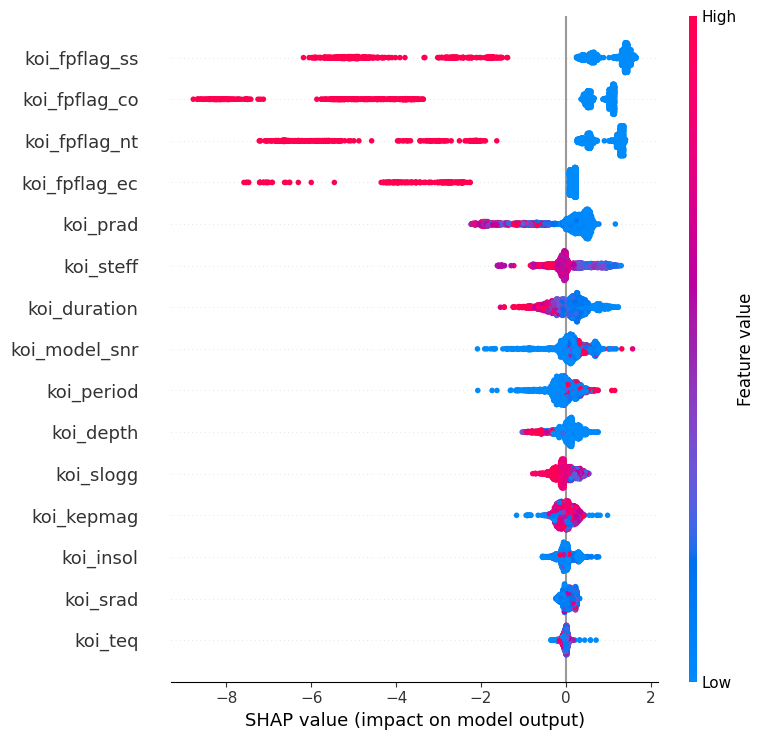

In [51]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled) 

In [52]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled)


Planet: nan


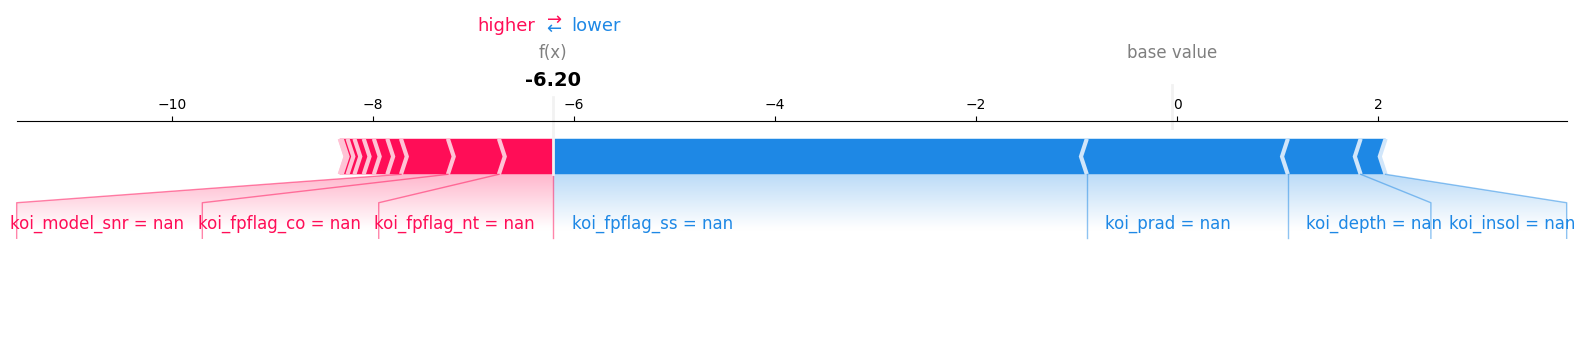

In [53]:
# Align indices
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Get SHAP force plot for a single planet
i = 0  # first planet in test set
planet_name = df.loc[X_test.index[i], 'kepler_name']  # or 'pl_name'
print("Planet:", planet_name)

shap.force_plot(
    explainer.expected_value,
    shap_values[i,:],
    X_test_scaled.iloc[i,:],
    matplotlib=True
)


Explaining: Kepler-1063 b


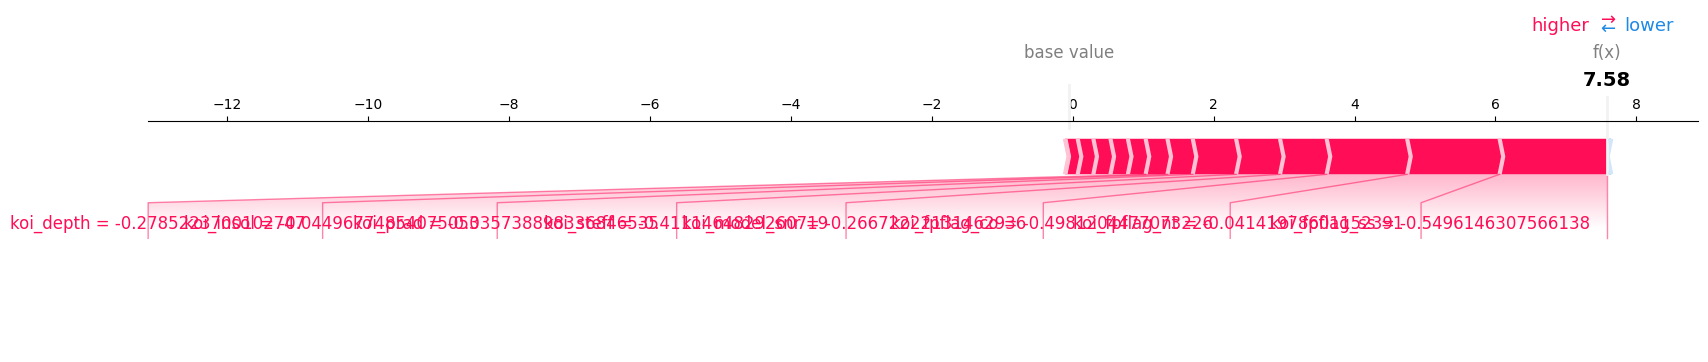

Explaining: Kepler-877 b


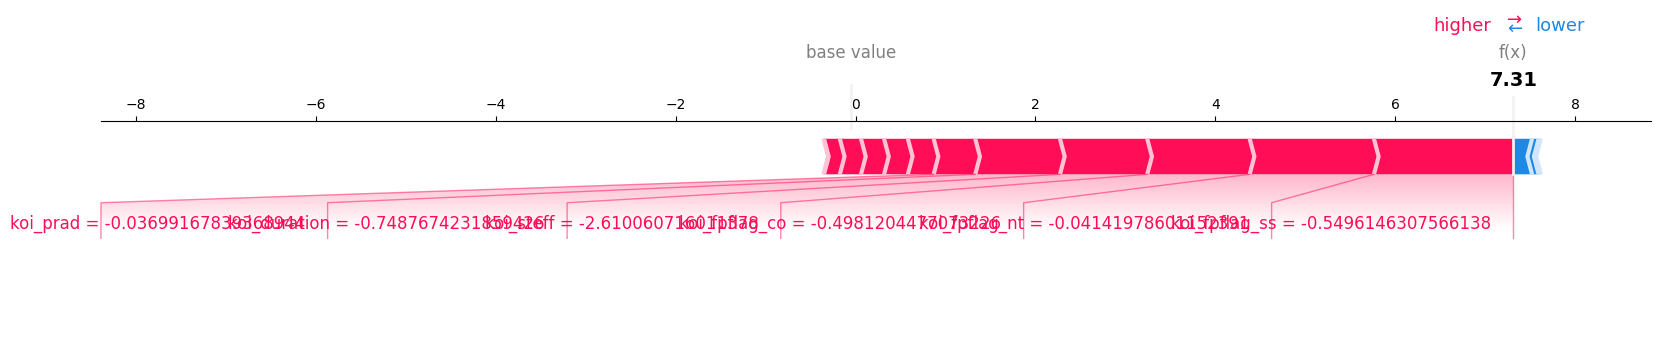

Explaining: nan


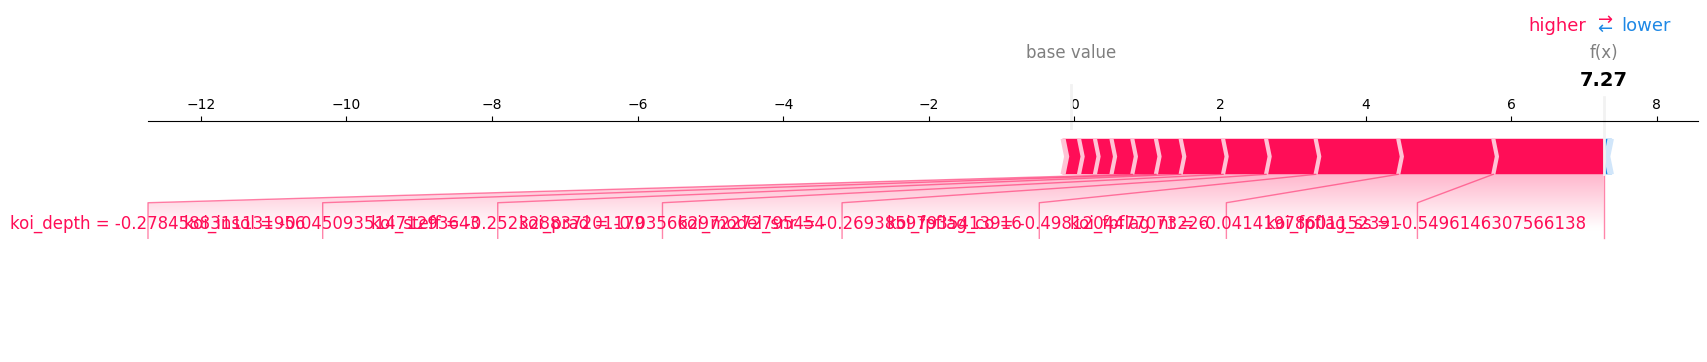

Explaining: nan


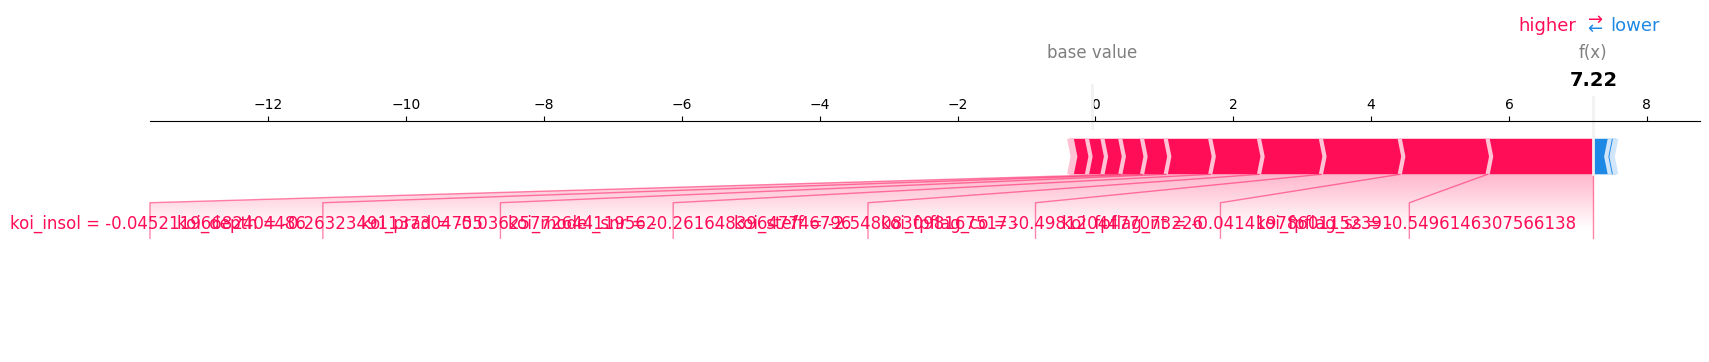

Explaining: Kepler-32 c


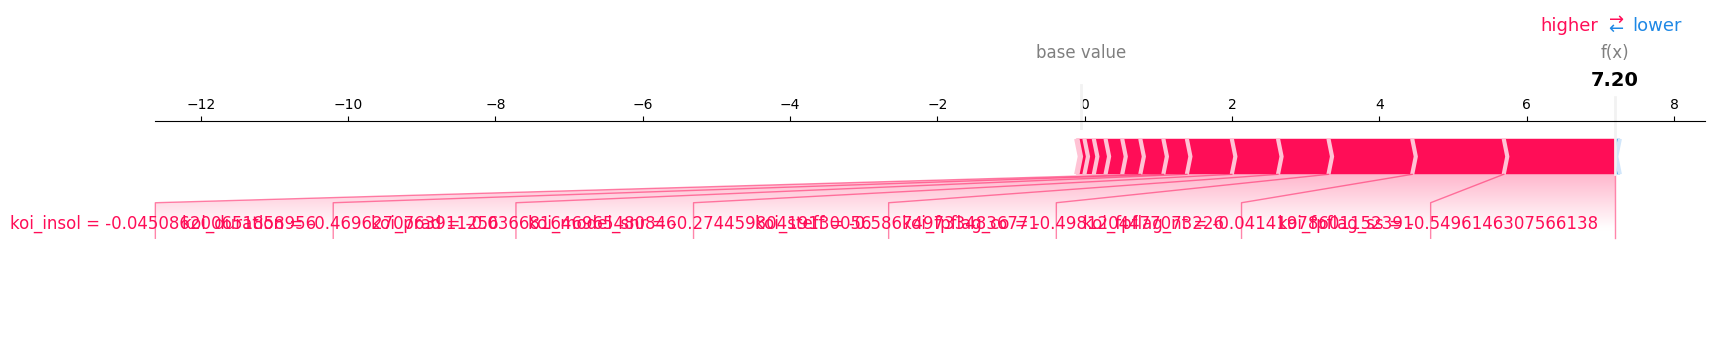

Explaining: Kepler-229 c


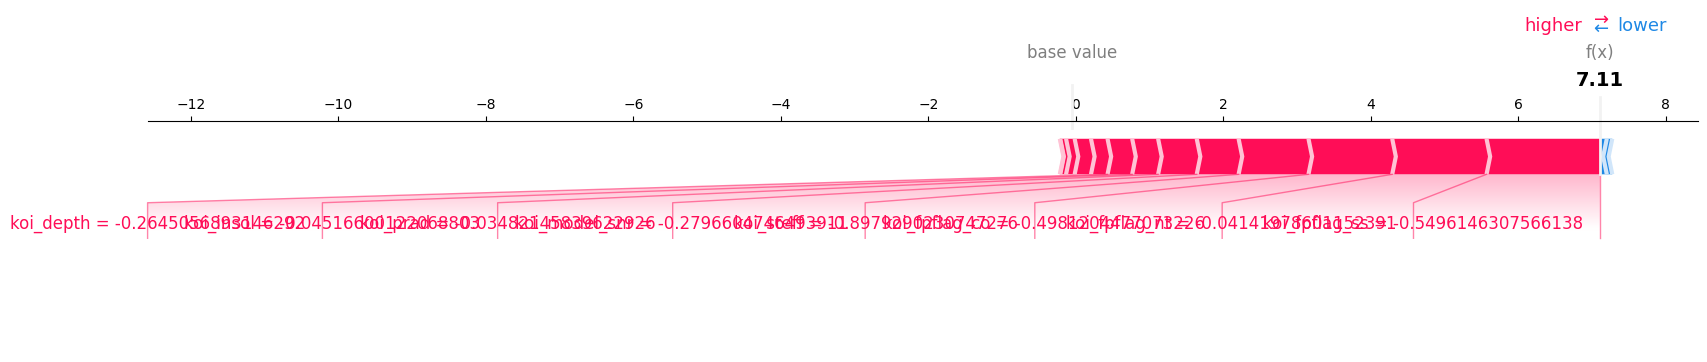

Explaining: Kepler-785 b


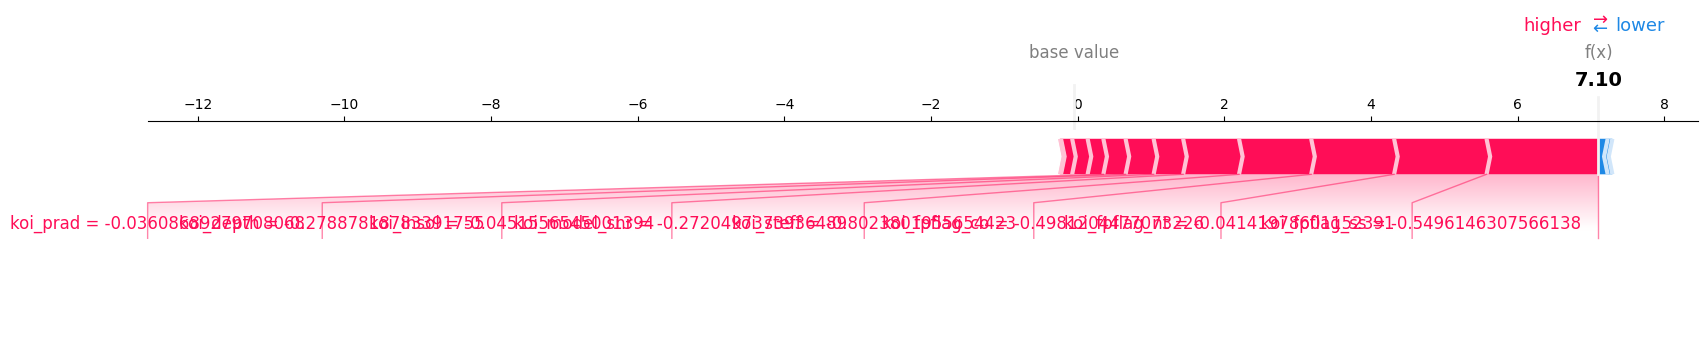

Explaining: Kepler-82 c


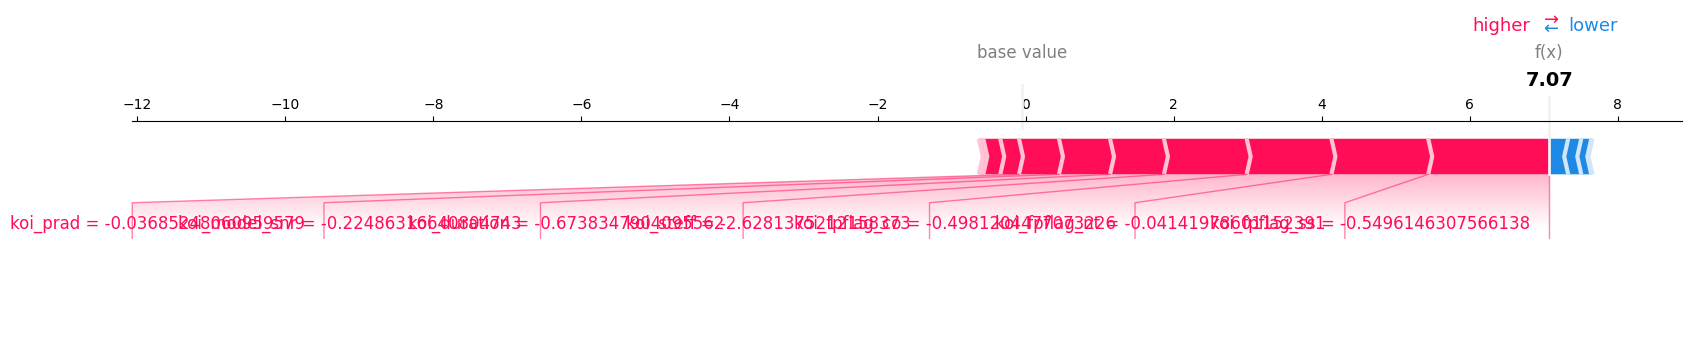

Explaining: Kepler-1818 b


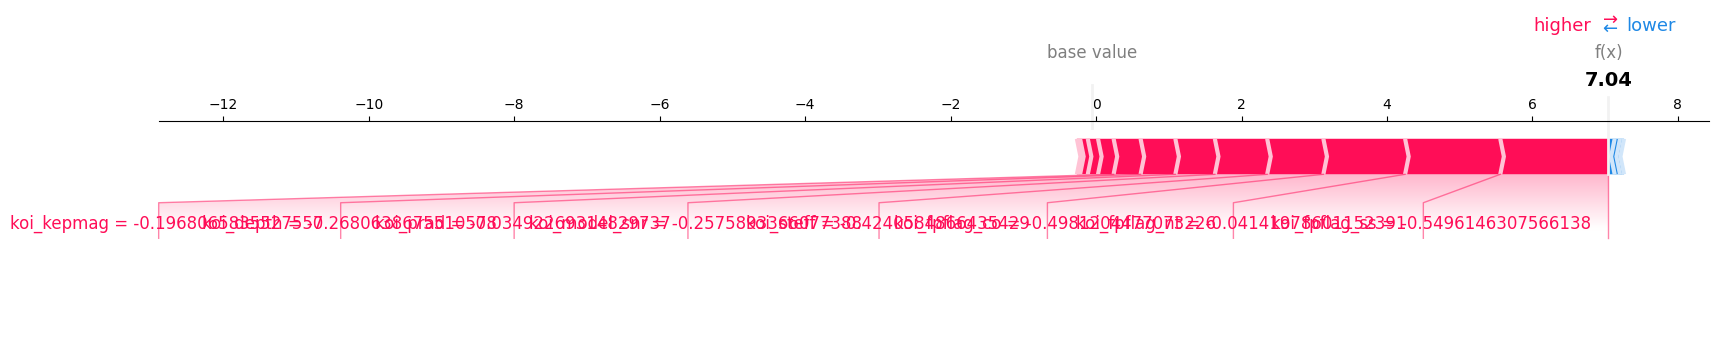

Explaining: nan


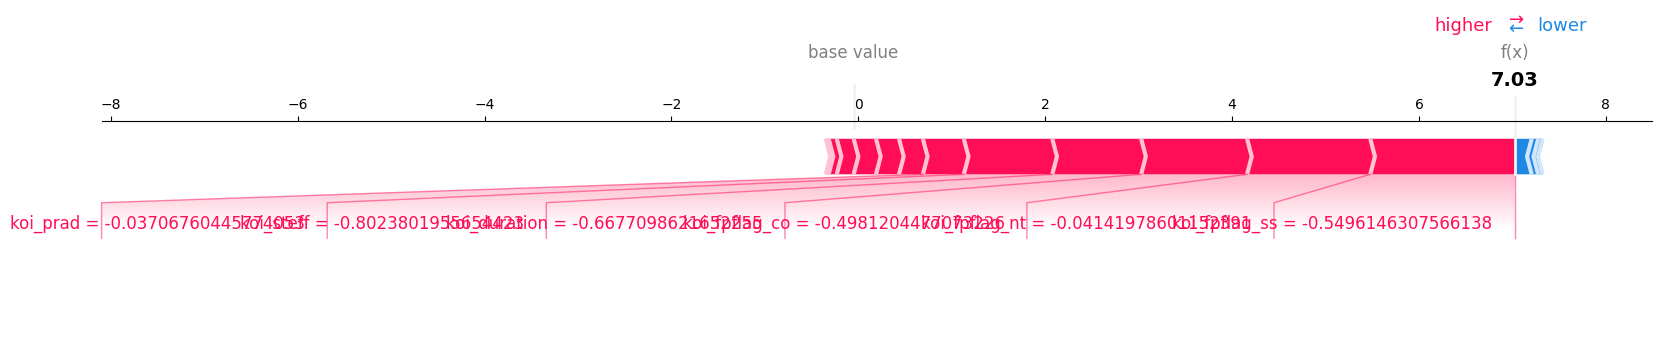

In [54]:
# Get probabilities
probs = xgb.predict_proba(X_test_scaled)[:,1]

X_test_scaled['probability'] = probs
X_test_scaled['planet_name'] = df.loc[X_test.index, 'kepler_name']

# Top candidates
top = X_test_scaled.sort_values('probability', ascending=False).head(10)

for idx in top.index:
    name = df.loc[idx, 'kepler_name']
    print("Explaining:", name)
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx,:],
        X_test_scaled.loc[idx, features],
        matplotlib=True
    )
